IMPORTING ALL THE LIBRARIES

In [41]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
import seaborn as sns 
import os 
from datetime import datetime 

import warnings 
warnings.filterwarnings("ignore") 

Load the dataset into the pandas dataframe

In [42]:
data = pd.read_csv('/kaggle/input/5-yrs-dataset/all_stocks_5yr.csv')
print(data.shape)
print(data.sample(7))

(619040, 7)
              date      open     high     low     close    volume  Name
407592  2013-05-16   35.2785   35.550   33.60   33.8614  28051415  NFLX
560967  2017-03-15  120.2800  121.820  120.05  121.4700    638690   UHS
75679   2014-04-07  127.1900  128.175  124.95  125.5900   3753854    BA
321212  2016-09-26   51.1200   51.990   51.04   51.5000   3213237   JWN
319824  2016-03-23   60.3400   60.510   59.86   59.9400  11658691   JPM
221983  2016-07-05  152.4700  153.063  150.35  152.1700   1917337   FDX
348264  2016-07-27   43.7000   43.920   43.10   43.3700   1927595   LNC


Since the given data consists of a date feature, this is more likely to be an ‘object’ data type

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


Pandas library helps us convert the object date feature to the DateTime data type

In [44]:
data['date'] = pd.to_datetime(data['date']) 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


Let us consider a few companies and visualize the distribution of open and closed Stock prices through 5 years

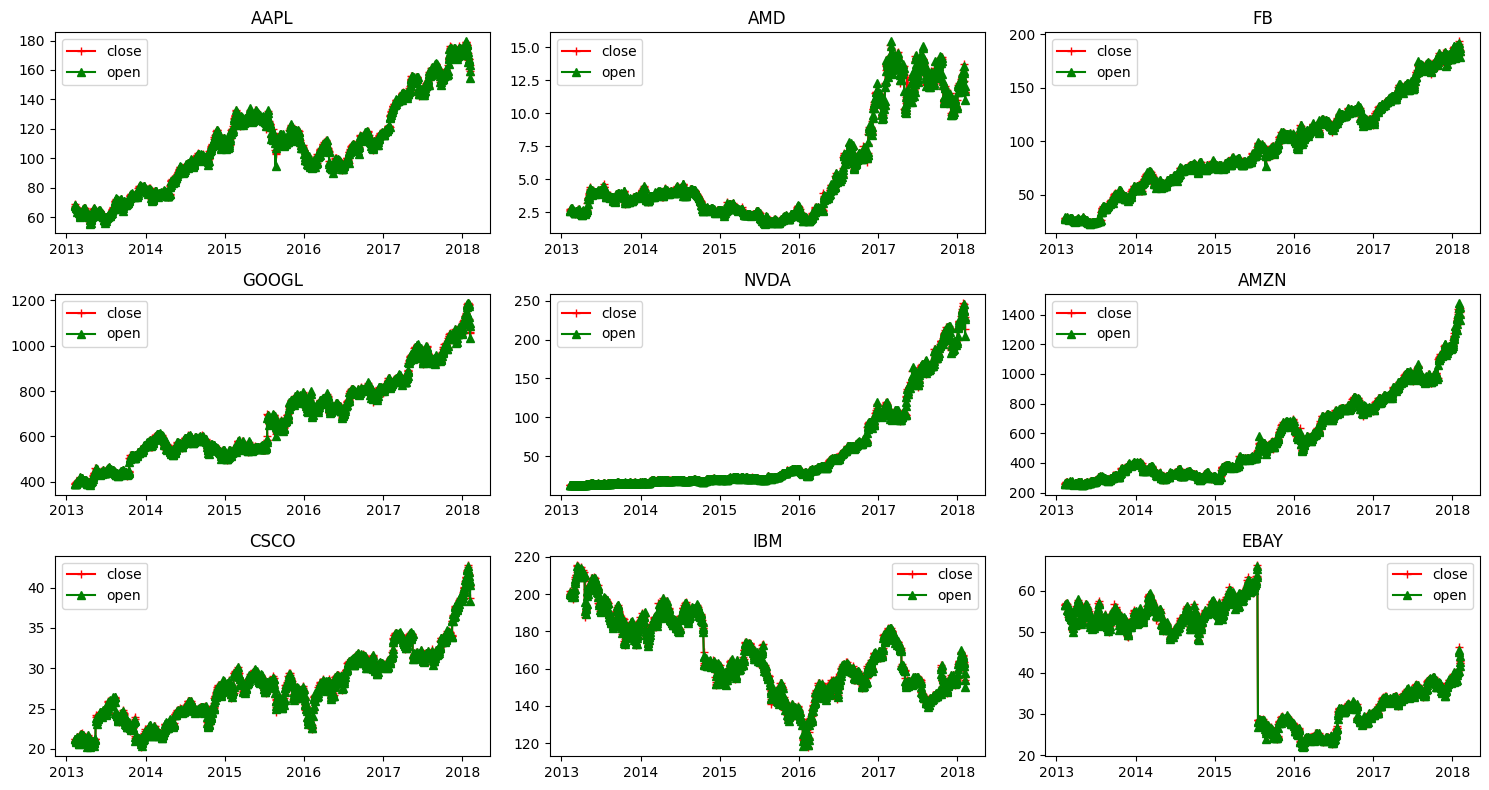

In [45]:
data['date'] = pd.to_datetime(data['date']) 
# date vs open 
# date vs close 

# Extract unique company names from the 'Name' column
companies = ['AAPL', 'AMD', 'FB', 'GOOGL', 'NVDA','AMZN', 'CSCO','IBM','EBAY']

plt.figure(figsize=(15, 8)) 
for index, company in enumerate(companies, 1): 
	plt.subplot(3, 3, index) 
	c = data[data['Name'] == company] 
	plt.plot(c['date'], c['close'], c="r", label="close", marker="+") 
	plt.plot(c['date'], c['open'], c="g", label="open", marker="^") 
	plt.title(company) 
	plt.legend() 
	plt.tight_layout() 


Plot the volume of trade for these 9 stocks as well as a function of time

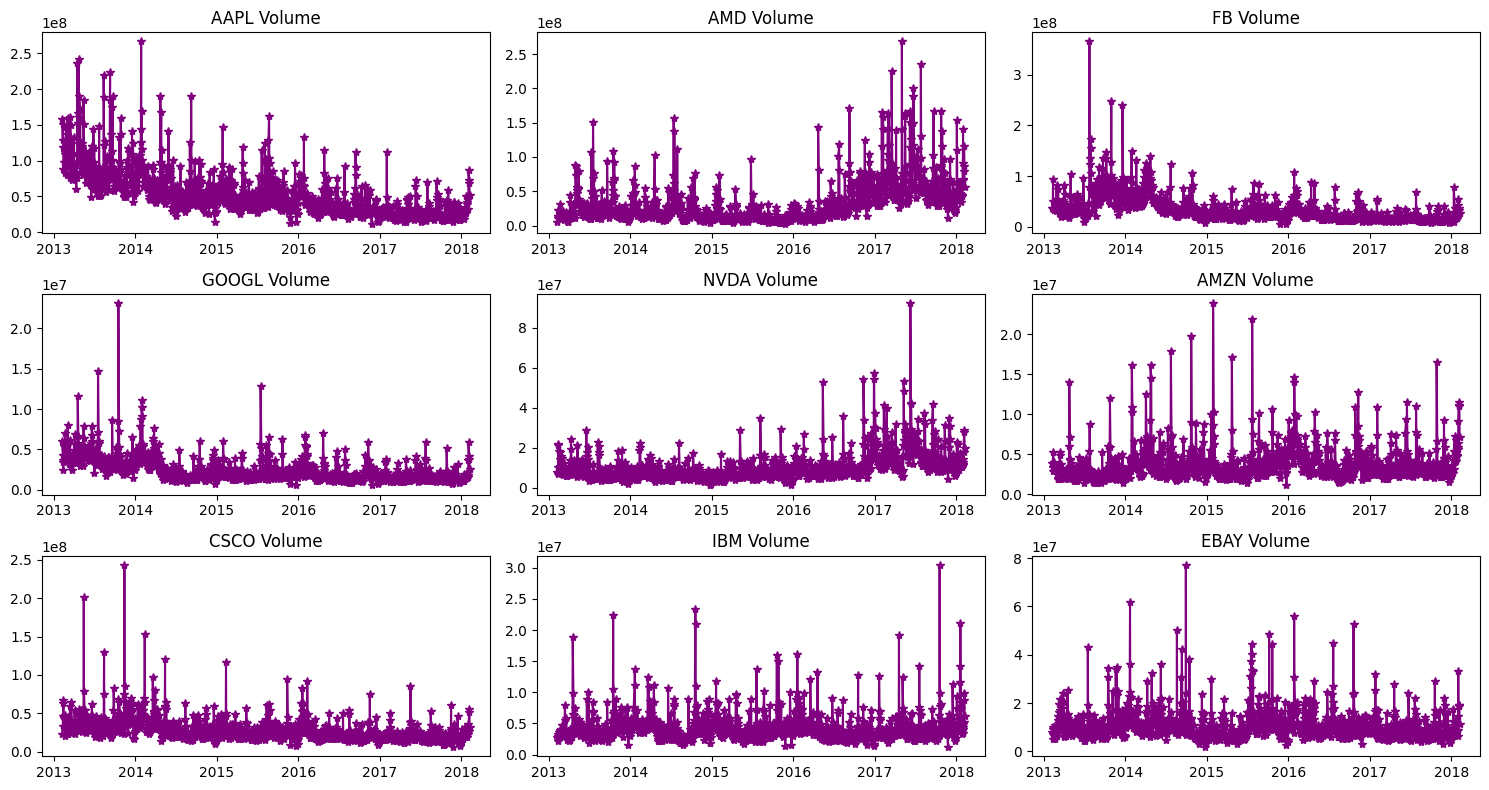

In [46]:
plt.figure(figsize=(15, 8)) 
for index, company in enumerate(companies, 1): 
	plt.subplot(3, 3, index) 
	c = data[data['Name'] == company] 
	plt.plot(c['date'], c['volume'], c='purple', marker='*') 
	plt.title(f"{company} Volume") 
	plt.tight_layout() 


Analyzing Apple stocks from '2013' to '2018'

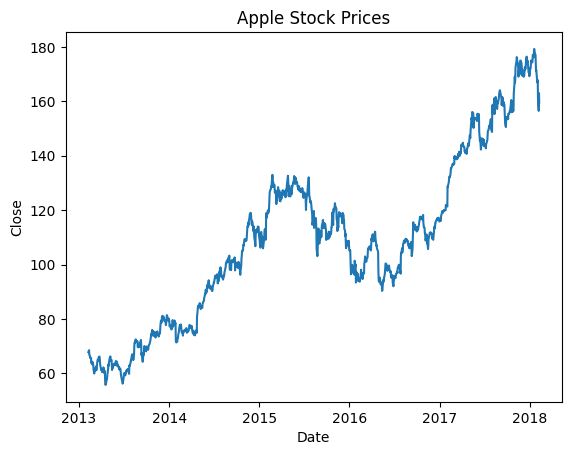

In [47]:
apple = data[data['Name'] == 'AAPL'] 
prediction_range = apple.loc[(apple['date'] > datetime(2013,1,1)) 
& (apple['date']<datetime(2018,1,1))] 
plt.plot(apple['date'],apple['close']) 
plt.xlabel("Date") 
plt.ylabel("Close") 
plt.title("Apple Stock Prices") 
plt.show()


Selecting a subset of whole data as the training data so, that we will be left with a subset of the data for the validation part as well

In [48]:
close_data = apple.filter(['close']) 
dataset = close_data.values 
training = int(np.ceil(len(dataset) * .95)) 
print(training) 

1197


We have the training data length, applying scaling and preparing features and labels that are x_train and y_train. 

In [49]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset) 

train_data = scaled_data[0:int(training), :] 
# prepare feature and labels 
x_train = [] 
y_train = [] 

for i in range(60, len(train_data)): 
	x_train.append(train_data[i-60:i, 0]) 
	y_train.append(train_data[i, 0]) 

x_train, y_train = np.array(x_train), np.array(y_train) 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 


Using TensorFlow, we can easily create LSTM-gated RNN cells. LSTM is used in Recurrent Neural Networks for sequence models and time series data. LSTM is used to avoid the vanishing gradient issue which is widely occurred in training RNN. To stack multiple LSTM in TensorFlow it is mandatory to use return_sequences = True. Since our data is time series varying we apply no activation to the output layer and it remains as 1 node. 

In [50]:
# Define the model
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))

# Print the model summary
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,033 (203.25 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 0 (0.00 B)

While compiling a model we provide these three essential parameters:

* optimizer – This is the method that helps to optimize the cost function by using gradient descent.
* loss – The loss function by which we monitor whether the model is improving with training or not.
* metrics – This helps to evaluate the model by predicting the training and the validation data.

In [51]:
#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error') 
history = model.fit(x_train, y_train, epochs=10) 


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0681
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0096
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0100
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0079
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0095
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0073
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0068
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0069
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0068
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0068


For predicting we require testing data, so we first create the testing data and then proceed with the model prediction. 

In [52]:
test_data = scaled_data[training - 60:, :] 
x_test = [] 
y_test = dataset[training:, :] 
for i in range(60, len(test_data)): 
	x_test.append(test_data[i-60:i, 0]) 

x_test = np.array(x_test) 
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1)) 

# predict the testing data 
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) 

# evaluation metrics 
mse = np.mean(((predictions - y_test) ** 2)) 
print("MSE", mse) 
print("RMSE", np.sqrt(mse)) 


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step
MSE 21.31249019003151
RMSE 4.616545265675569


Now that we have predicted the testing data, let us visualize the final results. 

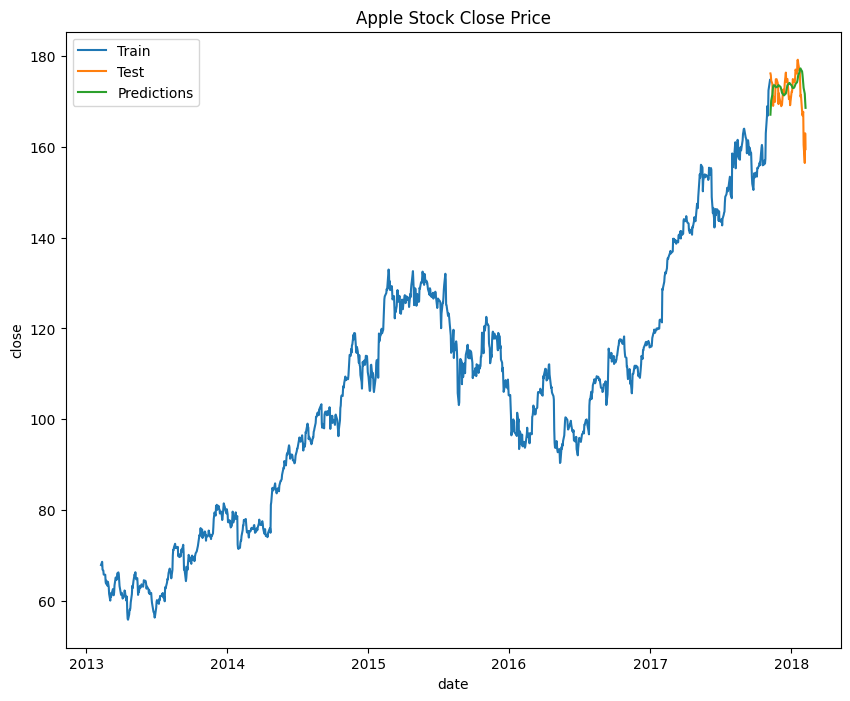

In [57]:
train = apple[:training] 
test = apple[training:] 
test['Predictions'] = predictions 

plt.figure(figsize=(10, 8)) 
plt.plot(train['date'], train['close']) 
plt.plot(test['date'], test[['close', 'Predictions']]) 
plt.title('Apple Stock Close Price') 
plt.xlabel('date') 
plt.ylabel("close") 
plt.legend(['Train', 'Test', 'Predictions']) 
